# Case 1: Pure Advection 

Running: Fine_Step (Steps=1000)...
Running: Coarse_Step (Steps=100)...


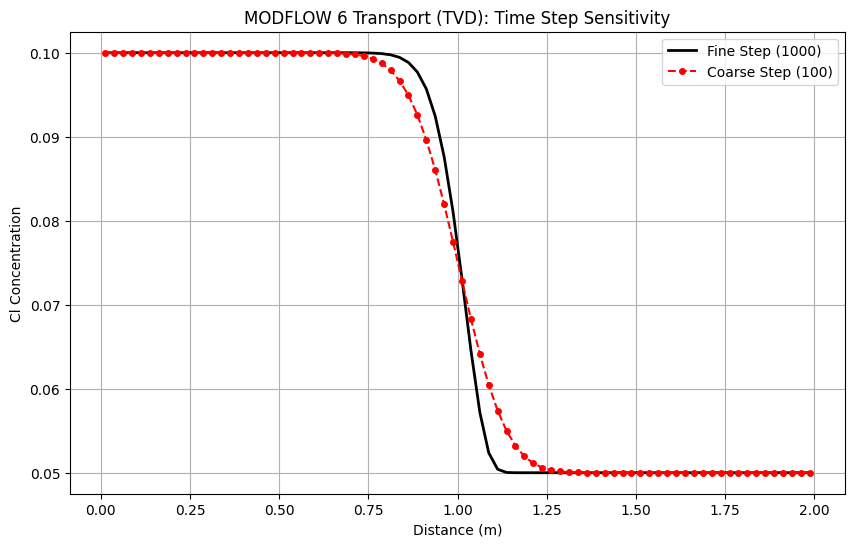

In [1]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

def transport_model(
    sim_name,
    nstp,          # Variable time steps for sensitivity analysis
    nrow=1,
    ncol=80,
    nlay=1,
    sim_ws="",
    species_list=["Ca", "Mg", "Cl"],
    perlen=10.0, # duration (10 days)
    bc=[0.1, 0.1, 0.1],
    porosity=0.35,
    K11=10.0,
    initial_head=0.0
):

    initial_conc = np.ones(nlay * nrow * ncol) * 0.05
    
    gwf_model_name = 'gwf_model'

    delr = [0.025] * ncol
    delc = [1.0]
    top = 1.0
    botm = 0

    nper = 1
    tsmult = 1.0
    hk = K11
    
    if os.path.exists(sim_ws):
        try:
            shutil.rmtree(sim_ws)
        except:
            pass

    sim = flopy.mf6.MFSimulation(
        sim_name="model",
        sim_ws=sim_ws,
        exe_name='./bin/mf6.exe', # ! Ensure path
        verbosity_level=0
    )

    flopy.mf6.ModflowTdis(
        sim,
        pname='tdis',
        time_units='DAYS',
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)]
    )

    gwf_model = flopy.mf6.ModflowGwf(
        sim, 
        modelname=gwf_model_name, 
        save_flows=True
    )
    
    ims = flopy.mf6.ModflowIms(
        sim,
        pname='ims',
        complexity='SIMPLE',
        outer_dvclose=1.0e-8,
        outer_maximum=50,
        under_relaxation='NONE',
        inner_maximum=100,
        inner_dvclose=1.0e-9,
        rcloserecord=1.0e-10,
        linear_acceleration='CG',
        scaling_method='NONE',
        reordering_method='NONE',
        relaxation_factor=0.97
    )
    sim.register_ims_package(ims, [gwf_model.name])

    flopy.mf6.ModflowGwfdis(
        gwf_model,
        pname='dis',
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm
    )

    flopy.mf6.ModflowGwfnpf(
        gwf_model,
        pname='npf',
        save_flows=True,
        save_specific_discharge=True,
        icelltype=0,
        k=hk,
        k33=hk*0.1
    )

    flopy.mf6.ModflowGwfic(
        gwf_model,
        pname='ic',
        strt=initial_head
    )

    flopy.mf6.ModflowGwfsto(
        gwf_model,
        pname='sto',
        save_flows=False,
        iconvert=1,
        ss=0.0,
        sy=0.0
    )

    # GHB Boundary Setup (Right: Outflow)
    ghb_spd = [[(0, 0, ncol-1), 0.0, 800.0]] 
    flopy.mf6.ModflowGwfghb(
        gwf_model,
        pname='ghb_right',
        save_flows=True,
        maxbound=len(ghb_spd),
        stress_period_data={0: ghb_spd},
        filename=f"{gwf_model_name}.choushui.ghb"
    )

    # GHB Boundary Setup (Left: Inflow with Source Concentration)
    ghb2_spd = [[(0, 0, 0), 0.007, 800.0, *bc]] 
    flopy.mf6.ModflowGwfghb(
        gwf_model,
        pname='bushui',
        save_flows=True,
        maxbound=len(ghb2_spd),
        stress_period_data={0: ghb2_spd},
        auxiliary=species_list,
        filename=f"{gwf_model_name}.bushui.ghb"
    )

    flopy.mf6.ModflowGwfoc(
        gwf_model,
        pname='oc',
        budget_filerecord=f'{gwf_model_name}.bud',
        head_filerecord=f'{gwf_model_name}.hds',
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'LAST')],
        printrecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')]
    )

    # ! ######################### Transport Models ######################### ! #

    species_conc = {}
    for i in range(len(species_list)):
        species_conc[species_list[i]] = initial_conc 

    # Solver settings for Transport
    nouter, ninner = 50, 100
    hclose, rclose, relax = 1e-6, 1e-6, 1.0
    alh = 0.0
    ath1 = alh / 10
    diffc = 0.0

    gwt_models = {}
    for species_name, species_initial_conc in species_conc.items():

        gwt_model_name = f"gwt_{species_name}_model"
        gwt_model = flopy.mf6.ModflowGwt(sim, modelname=gwt_model_name, save_flows=False, 
                                  model_nam_file=f"{gwt_model_name}.nam")

        imsgwt = flopy.mf6.ModflowIms(
            sim, 
            print_option="SUMMARY", 
            outer_dvclose=hclose, 
            outer_maximum=nouter,
            under_relaxation="NONE", 
            inner_maximum=ninner, 
            inner_dvclose=hclose,
            rcloserecord=rclose, 
            linear_acceleration="BICGSTAB",
            scaling_method="NONE", 
            reordering_method="NONE",
            relaxation_factor=relax, 
            filename=f"{gwt_model_name}.ims"
        )
        sim.register_ims_package(imsgwt, [gwt_model.name])
        
        flopy.mf6.ModflowGwtdis(
            gwt_model, 
            nlay=gwf_model.dis.nlay.get_data(), 
            nrow=gwf_model.dis.nrow.get_data(), 
            ncol=gwf_model.dis.ncol.get_data(), 
            delr=gwf_model.dis.delr.array, 
            delc=gwf_model.dis.delc.array, 
            top=gwf_model.dis.top.array,
            botm=gwf_model.dis.botm.array, 
            idomain=1, 
            filename=f"{gwt_model_name}.dis"
        )

        flopy.mf6.ModflowGwtic(gwt_model, strt=species_initial_conc, filename=f"{gwt_model_name}.ic")

        # ADVECTION SCHEME: Using TVD to minimize dispersion
        flopy.mf6.ModflowGwtadv(gwt_model, scheme="TVD", filename=f"{gwt_model_name}.adv")
        
        flopy.mf6.ModflowGwtdsp(
            gwt_model, 
            xt3d_off=True, 
            alh=alh, 
            ath1=ath1, 
            diffc=diffc,
            filename=f"{gwt_model_name}.dsp"
        )

        flopy.mf6.ModflowGwtmst(
            gwt_model, 
            pname='mst',
            porosity=porosity, 
            filename=f"{gwt_model_name}.mst")
        
        sourcerecarray = [("bushui", "AUX", species_name)]
        flopy.mf6.ModflowGwtssm(
            gwt_model, 
            pname=f'{species_name}_ssm',
            sources=sourcerecarray, 
            filename=f"{gwt_model_name}.ssm"
        )
        
        flopy.mf6.ModflowGwtoc(
            gwt_model, 
            budget_filerecord=f"{gwt_model_name}.cbc", 
            concentration_filerecord=f"{gwt_model_name}.ucn",
            saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")]
        )
        
        flopy.mf6.ModflowGwfgwt(
            sim, 
            exgtype="GWF6-GWT6", 
            exgmnamea=gwf_model_name, 
            exgmnameb=gwt_model_name, 
            filename=f"{gwt_model_name}.gwfgwt"
        )
        
        gwt_models[species_name] = gwt_model

    sim.write_simulation(silent=True)
    success, buff = sim.run_simulation(silent=True)
    if not success:
        print(f"Error running simulation {sim_name}")
        for line in buff[-10:]: print(line)
        raise Exception("Run Failed")
        
    return sim

# Scenario Settings
scenarios = {
    "Fine_Step":   1000,  # Small Time Steps (High Accuracy)
    "Coarse_Step": 100    # Large Time Steps (Showing Dispersion)
}

results = {}

try:
    for name, nstp_val in scenarios.items():
        print(f"Running: {name} (Steps={nstp_val})...")
        
        # Run Simulation
        sim = transport_model(
            sim_name=name,
            sim_ws=f"workspace_{name}",
            nstp=nstp_val
        )
        
        # Retrieve Concentration
        gwt_cl = sim.get_model("gwt_Cl_model")
        conc = gwt_cl.output.concentration().get_alldata()
        
        # Get data at the last time step
        results[name] = conc[-1, 0, 0, :]

    # ================= Plotting =================
    plt.figure(figsize=(10, 6))
    x = np.arange(80) * 0.025 + 0.025/2
    
    plt.plot(x, results["Fine_Step"], 'k-', linewidth=2, label='Fine Step (1000)')
    plt.plot(x, results["Coarse_Step"], 'r--', marker='o', markersize=4, label='Coarse Step (100)')
    
    plt.title("MODFLOW 6 Transport (TVD): Time Step Sensitivity")
    plt.xlabel("Distance (m)")
    plt.ylabel("Cl Concentration")
    plt.legend()
    plt.grid()
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")

# Case 2: Pure Diffusion

Running: Fine_Step (Steps=1000)...
Running: Coarse_Step (Steps=100)...


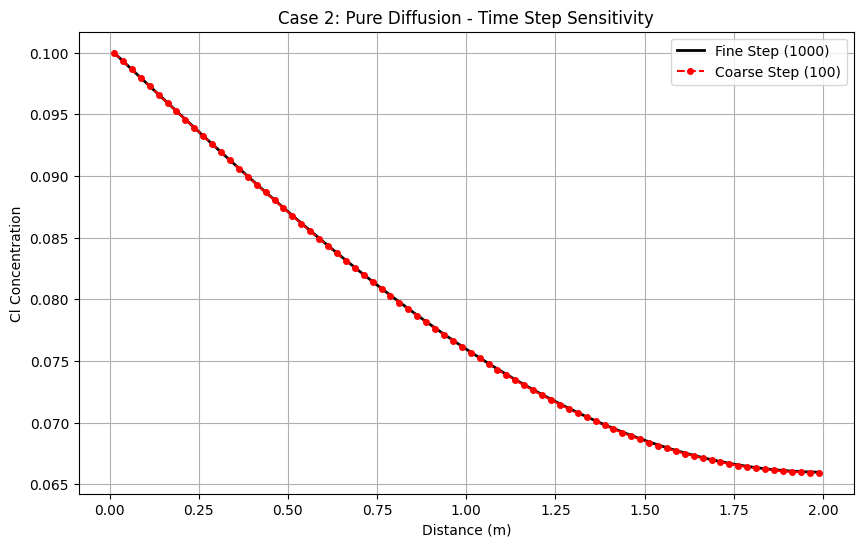

In [2]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

def transport_model(
    sim_name,
    nstp,
    nrow=1,
    ncol=80,
    nlay=1,
    sim_ws="",
    species_list=["Ca", "Mg", "Cl"],
    perlen=100.0,  # Simulation period length
    bc=[0.1, 0.1, 0.1],
    porosity=0.35,
    K11=10.0,
    initial_head=0.0
):
    initial_conc = np.ones(nlay * nrow * ncol) * 0.05
    
    gwf_model_name = 'gwf_model'

    delr = [0.025] * ncol
    delc = [1.0]
    top = 1.0
    botm = 0

    nper = 1
    tsmult = 1.0
    hk = K11
    
    if os.path.exists(sim_ws):
        try:
            shutil.rmtree(sim_ws)
        except:
            pass

    sim = flopy.mf6.MFSimulation(
        sim_name="model",
        sim_ws=sim_ws,
        exe_name='./bin/mf6.exe',
        verbosity_level=0
    )

    flopy.mf6.ModflowTdis(
        sim,
        pname='tdis',
        time_units='DAYS',
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)]
    )

    gwf_model = flopy.mf6.ModflowGwf(
        sim, 
        modelname=gwf_model_name, 
        save_flows=True
    )
    
    # Solver Settings
    ims = flopy.mf6.ModflowIms(
        sim,
        pname='ims',
        complexity='SIMPLE',
        outer_dvclose=1.0e-8,
        outer_maximum=50,
        under_relaxation='NONE',
        inner_maximum=100,
        inner_dvclose=1.0e-9,
        rcloserecord=1.0e-10,
        linear_acceleration='CG',
        scaling_method='NONE',
        reordering_method='NONE',
        relaxation_factor=0.97
    )
    sim.register_ims_package(ims, [gwf_model.name])

    flopy.mf6.ModflowGwfdis(
        gwf_model,
        pname='dis',
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm
    )

    flopy.mf6.ModflowGwfnpf(
        gwf_model,
        pname='npf',
        save_flows=True,
        save_specific_discharge=True,
        icelltype=0,
        k=hk,
        k33=hk*0.1
    )

    flopy.mf6.ModflowGwfic(
        gwf_model,
        pname='ic',
        strt=initial_head
    )

    flopy.mf6.ModflowGwfsto(
        gwf_model,
        pname='sto',
        save_flows=False,
        iconvert=1,
        ss=0.0,
        sy=0.0
    )

    # GHB Setup (Right Boundary)
    ghb_spd = [[(0, 0, ncol-1), 0.0, 800.0]] 
    flopy.mf6.ModflowGwfghb(
        gwf_model,
        pname='ghb_right',
        save_flows=True,
        maxbound=len(ghb_spd),
        stress_period_data={0: ghb_spd},
        filename=f"{gwf_model_name}.choushui.ghb"
    )

    # GHB Setup (Left Boundary)
    # Note: Head is set to 0.000 (same as right) -> No Advection
    ghb2_spd = [[(0, 0, 0), 0.000, 800.0, *bc]] 
    flopy.mf6.ModflowGwfghb(
        gwf_model,
        pname='bushui',
        save_flows=True,
        maxbound=len(ghb2_spd),
        stress_period_data={0: ghb2_spd},
        auxiliary=species_list,
        filename=f"{gwf_model_name}.bushui.ghb"
    )

    flopy.mf6.ModflowGwfoc(
        gwf_model,
        pname='oc',
        budget_filerecord=f'{gwf_model_name}.bud',
        head_filerecord=f'{gwf_model_name}.hds',
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'LAST')],
        printrecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')]
    )

    # ! ######################### Transport Models ######################### ! #

    species_conc = {}
    for i in range(len(species_list)):
        species_conc[species_list[i]] = initial_conc 

    nouter, ninner = 50, 100
    hclose, rclose, relax = 1e-6, 1e-6, 1.0
    
    # Diffusion Settings
    alh = 0.0
    ath1 = alh / 10
    diffc = 0.01  # Diffusion coefficient enabled

    bc_conc_map = dict(zip(species_list, bc))

    gwt_models = {}
    for species_name, species_initial_conc in species_conc.items():

        gwt_model_name = f"gwt_{species_name}_model"
        gwt_model = flopy.mf6.ModflowGwt(sim, modelname=gwt_model_name, save_flows=False, 
                                  model_nam_file=f"{gwt_model_name}.nam")

        imsgwt = flopy.mf6.ModflowIms(
            sim, 
            print_option="SUMMARY", 
            outer_dvclose=hclose, 
            outer_maximum=nouter,
            under_relaxation="NONE", 
            inner_maximum=ninner, 
            inner_dvclose=hclose,
            rcloserecord=rclose, 
            linear_acceleration="BICGSTAB",
            scaling_method="NONE", 
            reordering_method="NONE",
            relaxation_factor=relax, 
            filename=f"{gwt_model_name}.ims"
        )
        sim.register_ims_package(imsgwt, [gwt_model.name])
        
        flopy.mf6.ModflowGwtdis(
            gwt_model, 
            nlay=gwf_model.dis.nlay.get_data(), 
            nrow=gwf_model.dis.nrow.get_data(), 
            ncol=gwf_model.dis.ncol.get_data(), 
            delr=gwf_model.dis.delr.array, 
            delc=gwf_model.dis.delc.array, 
            top=gwf_model.dis.top.array,
            botm=gwf_model.dis.botm.array, 
            idomain=1, 
            filename=f"{gwt_model_name}.dis"
        )

        flopy.mf6.ModflowGwtic(gwt_model, strt=species_initial_conc, filename=f"{gwt_model_name}.ic")

        # Advection Package (Technically inactive due to zero gradient, but included)
        flopy.mf6.ModflowGwtadv(gwt_model, scheme="TVD", filename=f"{gwt_model_name}.adv")
        
        # Dispersion/Diffusion Package
        flopy.mf6.ModflowGwtdsp(
            gwt_model, 
            xt3d_off=True, 
            alh=alh, 
            ath1=ath1, 
            diffc=diffc,
            filename=f"{gwt_model_name}.dsp"
        )

        # Constant Concentration (CNC) at Boundary
        current_bc_conc = bc_conc_map[species_name]
        cnc_spd_list = [((0, 0, 0), current_bc_conc),]
        cnc_spd_dict = {0: cnc_spd_list}

        flopy.mf6.ModflowGwtcnc(
            gwt_model,
            maxbound=len(cnc_spd_list),
            stress_period_data=cnc_spd_dict,
            save_flows=False,
            print_input=False,
            pname=f"{gwt_model_name}.cnc"
        )

        flopy.mf6.ModflowGwtmst(
            gwt_model, 
            pname='mst',
            porosity=porosity, 
            filename=f"{gwt_model_name}.mst")
        
        sourcerecarray = [("bushui", "AUX", species_name)]
        flopy.mf6.ModflowGwtssm(
            gwt_model, 
            pname=f'{species_name}_ssm',
            sources=sourcerecarray, 
            filename=f"{gwt_model_name}.ssm"
        )
        
        flopy.mf6.ModflowGwtoc(
            gwt_model, 
            budget_filerecord=f"{gwt_model_name}.cbc", 
            concentration_filerecord=f"{gwt_model_name}.ucn",
            saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")]
        )
        
        flopy.mf6.ModflowGwfgwt(
            sim, 
            exgtype="GWF6-GWT6", 
            exgmnamea=gwf_model_name, 
            exgmnameb=gwt_model_name, 
            filename=f"{gwt_model_name}.gwfgwt"
        )
        
        gwt_models[species_name] = gwt_model

    sim.write_simulation(silent=True)
    success, buff = sim.run_simulation(silent=True)
    if not success:
        print(f"Error running simulation {sim_name}")
        for line in buff[-10:]: print(line)
        raise Exception("Run Failed")
        
    return sim

# Scenario Settings
scenarios = {
    "Fine_Step": 1000,   # Small Time Steps
    "Coarse_Step": 100   # Large Time Steps
}

results = {}

try:
    for name, nstp_val in scenarios.items():
        print(f"Running: {name} (Steps={nstp_val})...")
        
        # Run Simulation
        sim = transport_model(
            sim_name=name,
            sim_ws=f"workspace_{name}",
            nstp=nstp_val
        )
        
        # Retrieve Concentration
        gwt_cl = sim.get_model("gwt_Cl_model")
        conc = gwt_cl.output.concentration().get_alldata()
        
        # Get data at the last time step
        results[name] = conc[-1, 0, 0, :]

    # ================= Plotting =================
    plt.figure(figsize=(10, 6))
    x = np.arange(80) * 0.025 + 0.025/2
    
    # Plot Fine Step
    plt.plot(x, results["Fine_Step"], 'k-', linewidth=2, 
             label=f'Fine Step ({scenarios["Fine_Step"]})')
    
    # Plot Coarse Step
    plt.plot(x, results["Coarse_Step"], 'r--', marker='o', markersize=4, 
             label=f'Coarse Step ({scenarios["Coarse_Step"]})')
    
    plt.title("Case 2: Pure Diffusion - Time Step Sensitivity")
    plt.xlabel("Distance (m)")
    plt.ylabel("Cl Concentration")
    plt.legend()
    plt.grid()
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")